# IMPORT LIBRARY

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras import layers
from keras.metrics import Precision, Recall

# LOAD DATASETS

In [ ]:
dataset_path = "datasets"

rows = []

for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_folder):
        for filename in os.listdir(class_folder):
            file_path = os.path.join(class_folder, filename)
            rows.append({
                "filepath": file_path,
                "label": class_name
            })

df = pd.DataFrame(rows)
df.head()


,filepath,label
0,datasets\cane\OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg,cane
1,datasets\cane\OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg,cane
2,datasets\cane\OIP---cByAiEbIxIAleGo9AqOQAAAA.jpeg,cane
3,datasets\cane\OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg,cane
4,datasets\cane\OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg,cane


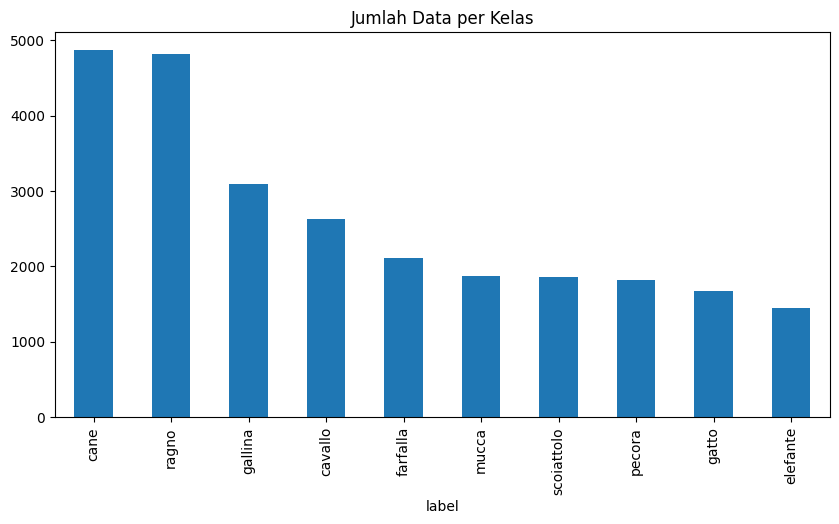

In [ ]:
df['label'].value_counts().plot(kind='bar', figsize=(10,5), title='Jumlah Data per Kelas');

# ENCODE

In [ ]:
label_to_idx = {label: idx for idx, label in enumerate(df["label"].unique())}
idx_to_label = {v: k for k, v in label_to_idx.items()}

df["label_idx"] = df["label"].map(label_to_idx)
num_classes = df["label_idx"].nunique()

df.head()


,filepath,label,label_idx
0,datasets\cane\OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg,cane,0
1,datasets\cane\OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg,cane,0
2,datasets\cane\OIP---cByAiEbIxIAleGo9AqOQAAAA.jpeg,cane,0
3,datasets\cane\OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg,cane,0
4,datasets\cane\OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg,cane,0


# RESIZE + NORMALISASI (PREPROCESSING)

In [ ]:
IMG_SIZE = (224, 224)

def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)

    img.set_shape([None, None, 3])  # FIX WARNA PENTING 🔥

    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label


In [ ]:
filepaths = df["filepath"].values
labels = df["label_idx"].values

ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.cache()
ds = ds.shuffle(buffer_size=len(df))
ds


<_ShuffleDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

# DATA SPLIT

In [ ]:
total = len(df)
train_size = int(0.7 * total)
val_size   = int(0.15 * total)
test_size  = total - train_size - val_size

train_ds = ds.take(train_size)
val_ds   = ds.skip(train_size).take(val_size)
test_ds  = ds.skip(train_size + val_size)


# BATCH + PREFETCH

In [ ]:
BATCH_SIZE = 32

train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# MEMBUAT MODEL CNN

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="data_augmentation")

model = keras.Sequential([

    keras.Input(shape=(224, 224, 3)),

    # BLOCK 1
    layers.Conv2D(32, (3,3), activation='relu', padding="same"),
    layers.MaxPooling2D(),

    # BLOCK 2
    layers.Conv2D(64, (3,3), activation='relu', padding="same"),
    layers.MaxPooling2D(),

    # BLOCK 3
    layers.Conv2D(128, (3,3), activation='relu', padding="same"),
    layers.MaxPooling2D(),

    # BLOCK 4 (RINGANKAN)
    layers.Conv2D(128, (3,3), activation='relu', padding="same"),
    layers.MaxPooling2D(),

    # CLASSIFIER
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,514 (13.17 MB)

 Trainable params: 3,453,514 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

# CALLBACKS

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        "model.h5",
        save_best_only=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        patience=3,
        factor=0.5
    )
]


# TRAINNING

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.2482 - loss: 2.1166

573/573 ━━━━━━━━━━━━━━━━━━━━ 288s 393ms/step - accuracy: 0.2946 - loss: 2.0043 - val_accuracy: 0.4628 - val_loss: 1.6760 - learning_rate: 0.0010
Epoch 2/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.4244 - loss: 1.6788

573/573 ━━━━━━━━━━━━━━━━━━━━ 215s 375ms/step - accuracy: 0.4491 - loss: 1.6084 - val_accuracy: 0.5469 - val_loss: 1.3178 - learning_rate: 0.0010
Epoch 3/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.5228 - loss: 1.3901

573/573 ━━━━━━━━━━━━━━━━━━━━ 243s 424ms/step - accuracy: 0.5349 - loss: 1.3583 - val_accuracy: 0.6281 - val_loss: 1.1375 - learning_rate: 0.0010
Epoch 4/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.5789 - loss: 1.2364

573/573 ━━━━━━━━━━━━━━━━━━━━ 237s 414ms/step - accuracy: 0.5886 - loss: 1.2105 - val_accuracy: 0.6615 - val_loss: 0.9830 - learning_rate: 0.0010
Epoch 5/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.6272 - loss: 1.1033

573/573 ━━━━━━━━━━━━━━━━━━━━ 249s 434ms/step - accuracy: 0.6362 - loss: 1.0798 - val_accuracy: 0.7394 - val_loss: 0.7799 - learning_rate: 0.0010
Epoch 6/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.6688 - loss: 0.9611

573/573 ━━━━━━━━━━━━━━━━━━━━ 224s 391ms/step - accuracy: 0.6711 - loss: 0.9642 - val_accuracy: 0.7881 - val_loss: 0.6554 - learning_rate: 0.0010
Epoch 7/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.7036 - loss: 0.8596

573/573 ━━━━━━━━━━━━━━━━━━━━ 233s 407ms/step - accuracy: 0.7026 - loss: 0.8623 - val_accuracy: 0.7906 - val_loss: 0.6001 - learning_rate: 0.0010
Epoch 8/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.7397 - loss: 0.7611

573/573 ━━━━━━━━━━━━━━━━━━━━ 245s 427ms/step - accuracy: 0.7398 - loss: 0.7663 - val_accuracy: 0.8293 - val_loss: 0.5184 - learning_rate: 0.0010
Epoch 9/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.7700 - loss: 0.6622

573/573 ━━━━━━━━━━━━━━━━━━━━ 242s 423ms/step - accuracy: 0.7656 - loss: 0.6745 - val_accuracy: 0.8500 - val_loss: 0.4507 - learning_rate: 0.0010
Epoch 10/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7872 - loss: 0.6133

573/573 ━━━━━━━━━━━━━━━━━━━━ 237s 414ms/step - accuracy: 0.7868 - loss: 0.6126 - val_accuracy: 0.8752 - val_loss: 0.3862 - learning_rate: 0.0010
Epoch 11/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8112 - loss: 0.5407

573/573 ━━━━━━━━━━━━━━━━━━━━ 221s 386ms/step - accuracy: 0.8095 - loss: 0.5532 - val_accuracy: 0.9098 - val_loss: 0.3117 - learning_rate: 0.0010
Epoch 12/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8299 - loss: 0.4923

573/573 ━━━━━━━━━━━━━━━━━━━━ 233s 406ms/step - accuracy: 0.8243 - loss: 0.5047 - val_accuracy: 0.9190 - val_loss: 0.2830 - learning_rate: 0.0010
Epoch 13/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8429 - loss: 0.4371

573/573 ━━━━━━━━━━━━━━━━━━━━ 250s 436ms/step - accuracy: 0.8424 - loss: 0.4497 - val_accuracy: 0.9251 - val_loss: 0.2378 - learning_rate: 0.0010
Epoch 14/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.8571 - loss: 0.4084

573/573 ━━━━━━━━━━━━━━━━━━━━ 245s 428ms/step - accuracy: 0.8548 - loss: 0.4138 - val_accuracy: 0.9422 - val_loss: 0.1807 - learning_rate: 0.0010
Epoch 15/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.8699 - loss: 0.3658

573/573 ━━━━━━━━━━━━━━━━━━━━ 243s 424ms/step - accuracy: 0.8655 - loss: 0.3765 - val_accuracy: 0.9580 - val_loss: 0.1559 - learning_rate: 0.0010
Epoch 16/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8817 - loss: 0.3337

573/573 ━━━━━━━━━━━━━━━━━━━━ 242s 422ms/step - accuracy: 0.8794 - loss: 0.3445 - val_accuracy: 0.9592 - val_loss: 0.1395 - learning_rate: 0.0010
Epoch 17/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8858 - loss: 0.3232

573/573 ━━━━━━━━━━━━━━━━━━━━ 246s 429ms/step - accuracy: 0.8825 - loss: 0.3293 - val_accuracy: 0.9674 - val_loss: 0.1119 - learning_rate: 0.0010
Epoch 18/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 242s 422ms/step - accuracy: 0.8942 - loss: 0.2945 - val_accuracy: 0.9485 - val_loss: 0.1545 - learning_rate: 0.0010
Epoch 19/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8906 - loss: 0.2960

573/573 ━━━━━━━━━━━━━━━━━━━━ 242s 422ms/step - accuracy: 0.8958 - loss: 0.2850 - val_accuracy: 0.9840 - val_loss: 0.0715 - learning_rate: 0.0010
Epoch 20/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9024 - loss: 0.2669

573/573 ━━━━━━━━━━━━━━━━━━━━ 237s 414ms/step - accuracy: 0.9032 - loss: 0.2709 - val_accuracy: 0.9806 - val_loss: 0.0686 - learning_rate: 0.0010


# PLOT AKURASI DAN LOSS

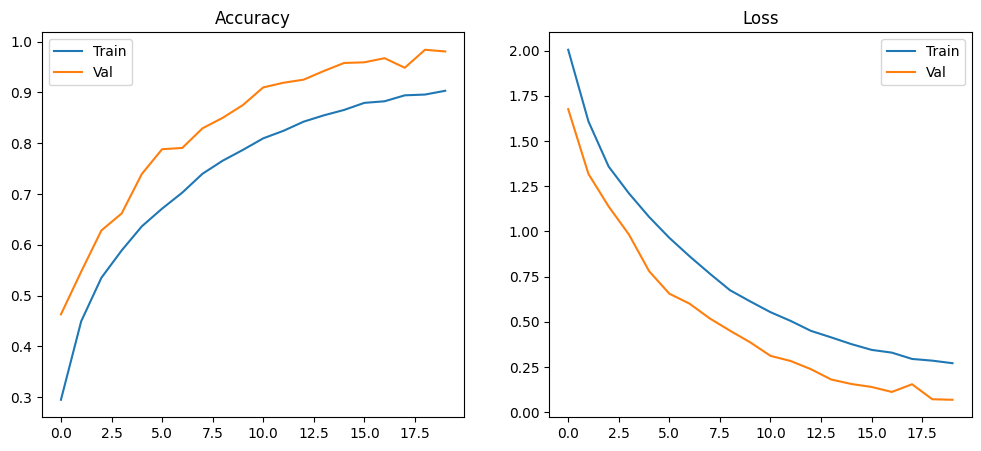

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.legend(["Train", "Val"])

plt.subplot(1,2,2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.legend(["Train", "Val"])

plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.9809 - loss: 0.0727
Test Accuracy: 0.9809063076972961


In [ ]:
model.save("model.h5")

# SAVEDMODEL

In [ ]:
model = keras.models.load_model("model.h5")

In [ ]:
model.export("saved_model")

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1411245972304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1411245973456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1411245974416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1411245973840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1411245974992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1411245975184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1411245975568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1411245975760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1411245974608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1411245974032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1411245976912: TensorSpec(shape=(), dty

# TF LITE

In [ ]:
os.makedirs("tflite", exist_ok=True)

# convert SavedModel ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

# simpan ke lokasi yang benar
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model TFLite berhasil disimpan di: tflite/model.tflite")

Model TFLite berhasil disimpan di: tflite/model.tflite


In [ ]:
# Ambil semua nama kelas unik dan urutkan
class_names = sorted(df["label"].unique())

class_names


['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

In [ ]:
# tulis label.txt
with open("tflite/label.txt", "w") as f:
    for label in class_names:
        f.write(label + "\n")

print("label.txt berhasil dibuat di folder tflite/")

label.txt berhasil dibuat di folder tflite/


# TFJS

In [1]:
!pip install tensorflowjs

In [3]:
import zipfile
with zipfile.ZipFile("saved_model.zip", "r") as z:
    z.extractall()

In [5]:
!tensorflowjs_converter --input_format=tf_saved_model \
    saved_model \
    tfjs_model

2025-12-01 10:39:04.128162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764585544.153283    4118 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764585544.160809    4118 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764585544.179401    4118 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764585544.179450    4118 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764585544.179457    4118 computation_placer.cc:177] computation placer alr